Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

torch: 1.10.1



# AlexNet CIFAR-10 Classifier

### Network Architecture

References
    
- [1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "[Imagenet classification with deep convolutional neural networks.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.


## Imports

In [2]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

#### Setting a random seed

I recommend using a function like the following one prior to using dataset loaders and initializing a model if you want to ensure the data is shuffled in the same manner if you rerun this notebook and the model gets the same initial random weights:

In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#### Setting cuDNN and PyTorch algorithmic behavior to deterministic

Similar to the `set_all_seeds` function above, I recommend setting the behavior of PyTorch and cuDNN to deterministic (this is particulary relevant when using GPUs). We can also define a function for that:

In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [5]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

#### Import utility functions

In [6]:
import sys

sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

## Dataset

In [7]:
### Set random seed ###
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

train_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.CenterCrop((64, 64)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [9]:
##########################
### MODEL
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [10]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=50)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3033
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0240
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.9445
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.8135
***Epoch: 001/040 | Train. Acc.: 33.674% | Loss: 1.703
***Epoch: 001/040 | Valid. Acc.: 34.880% | Loss: 1.670
Time elapsed: 1.05 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.7606
Epoch: 002/040 | Batch 0050/0175 | Loss: 1.5473
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.5496
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.5093
***Epoch: 002/040 | Train. Acc.: 42.819% | Loss: 1.505
***Epoch: 002/040 | Valid. Acc.: 43.840% | Loss: 1.491
Time elapsed: 2.09 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.5411
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.5485
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.3723
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.3084
***Epoch: 003/040 | Train. Acc.: 49.712% | Loss: 1.336
***Epoch: 003/040 | Valid. Acc.: 50.300% | Loss: 1.327
Time elapsed: 3.12 min
Epoch: 004/040 | Batch 00

## Evaluation

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


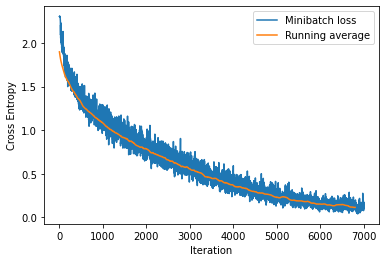

In [14]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

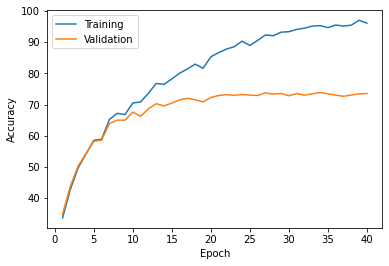

In [17]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 73.52%
Validation ACC: 73.52%
Test ACC: 72.11%


In [19]:
%watermark -iv

sys        : 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
matplotlib : 3.3.4
PIL        : 9.0.1
torchvision: 0.11.2
numpy      : 1.22.0
torch      : 1.10.1
pandas     : 1.4.1

